In [1]:
curr_box = 'Box_n50_0_1400'
jackknife_covs_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+curr_box+'_jackknife_covs.pkl'
NvM_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+curr_box+'_NvsM.pkl'


In [2]:
import pickle
jackknife_covs_f = open(jackknife_covs_fname, 'rb')
jackknife = pickle.load(jackknife_covs_f)
jackknife_covs_f.close()


NvM_f = open(NvM_fname, 'rb')
NvMs = pickle.load(NvM_f)
NvM_f.close()

In [3]:
import numpy as np
curr_a = list(jackknife.keys())[-1]
curr_var = np.diag(jackknife[curr_a][1])

In [4]:
NvMs[curr_a].keys()

dict_keys(['M', 'N', 'vol', 'Mpart', 'edge_pairs', 'bin_idx', 'corrections'])

In [5]:
curr_N = NvMs[curr_a]['N']
curr_M = np.array(NvMs[curr_a]['M'])

curr_edge_pairs = NvMs[curr_a]['edge_pairs']

In [6]:
import pyccl as ccl
from aemulusnu_hmf.emulator import get_cosmology


h = 0.6724
cosmology = {'ns': 0.97,
 'H0': h * 100,
 'w0': -1.0,
 'ombh2': 0.0223,
 'omch2': 0.12,
 'nu_mass_ev': 0.07,
 '10^9 As': 2.1}
hmf_cosmology = get_cosmology(cosmology)

cosmo = ccl.Cosmology(Omega_b=cosmology['ombh2']/h**2, 
                      Omega_c=cosmology['omch2']/h**2, 
                      h=h, 
                      A_s=cosmology['10^9 As'] * 1e-9, 
                      n_s=cosmology['ns'])

halo_bias = ccl.halos.HaloBiasTinker10()
bh = halo_bias(cosmo, curr_M / h, a=curr_a)

initializing cosmology. this will only happen once per cosmology


In [7]:
def integrand(logkx, logky, logkz):
#     print(logkx, logky, logkz)
    kx = np.exp(logkx)
    ky = np.exp(logky)
    kz = np.exp(logkz)
    k = np.sqrt(kx**2 + ky**2 + kz**2)

    z=1/curr_a - 1
    
    oup = 1/(2*np.pi)**3 * hmf_cosmology.pkclass.pk_cb_lin(k * hmf_cosmology.h, z) * hmf_cosmology.h ** 3
    for ki in [kx, ky, kz]:
        arg = ki * 1050 / 2
        oup *= (np.sin(arg) / arg) **2
    return oup * kx * ky * kz
import cProfile
cProfile.run('integrand(-1, -1, -1)')

         4 function calls in 0.000 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 49526050.py:1(integrand)
        1    0.000    0.000    0.000    0.000 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




$$n(M;x,z) = \bar n  + \delta n = \bar n(1 + b \delta) $$
window function is a cube 
$$n(M,z) = \int d^3 x \frac 1 {\rm vol} \times n(M;x,z) $$
$${\rm var}(n(M,z)) = b^2 \bar n^2 \int_{\vec k} P(k) \prod_{i=x,y,z} {\rm sinc}^2(k_i L / x) $$

In [70]:
from tqdm import trange
def triple_trapz(f, x_range, y_range, z_range, nx=50, ny=50, nz=50):
    x = np.linspace(x_range[0], x_range[1], nx)
    y = np.linspace(y_range[0], y_range[1], ny)
    z = np.linspace(z_range[0], z_range[1], nz)
    
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    dz = z[1] - z[0]
    
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
    
    #not vectorized bc class pk not vectorized
    F = np.zeros_like(X)
    for i in trange(nx):
        for j in range(ny):
            for k in range(nz):
                F[i,j,k] = f(X[i,j,k], Y[i,j,k], Z[i,j,k])
    
    F[0,:,:] *= 0.5
    F[-1,:,:] *= 0.5
    F[:,0,:] *= 0.5
    F[:,-1,:] *= 0.5
    F[:,:,0] *= 0.5
    F[:,:,-1] *= 0.5
    
    return np.sum(F) * dx * dy * dz


# Example usage for your case:
integral = triple_trapz(integrand, 
                     x_range=(-50, 3),
                     y_range=(-50, 3),
                     z_range=(-50, 3),
                     nx=500, ny=500, nz=500)

100%|██████████| 500/500 [26:57<00:00,  3.24s/it]


In [79]:
from scipy.integrate import tplquad

mbox = 1050**3 * hmf_cosmology.f_rho_cb(0.0)
sigma_cb = hmf_cosmology.sigma_cb(mbox, z=1/curr_a - 1)

sample_variance = bh**2 * curr_N**2 
sample_variance *= integral * 8
# factor of 8 bc used symmetry to change int_-inf^inf -> 2 * int_0^inf for dkx, dky, and dkz

In [80]:
curr_bin_edges = [pair[0] for pair in curr_edge_pairs]

[]

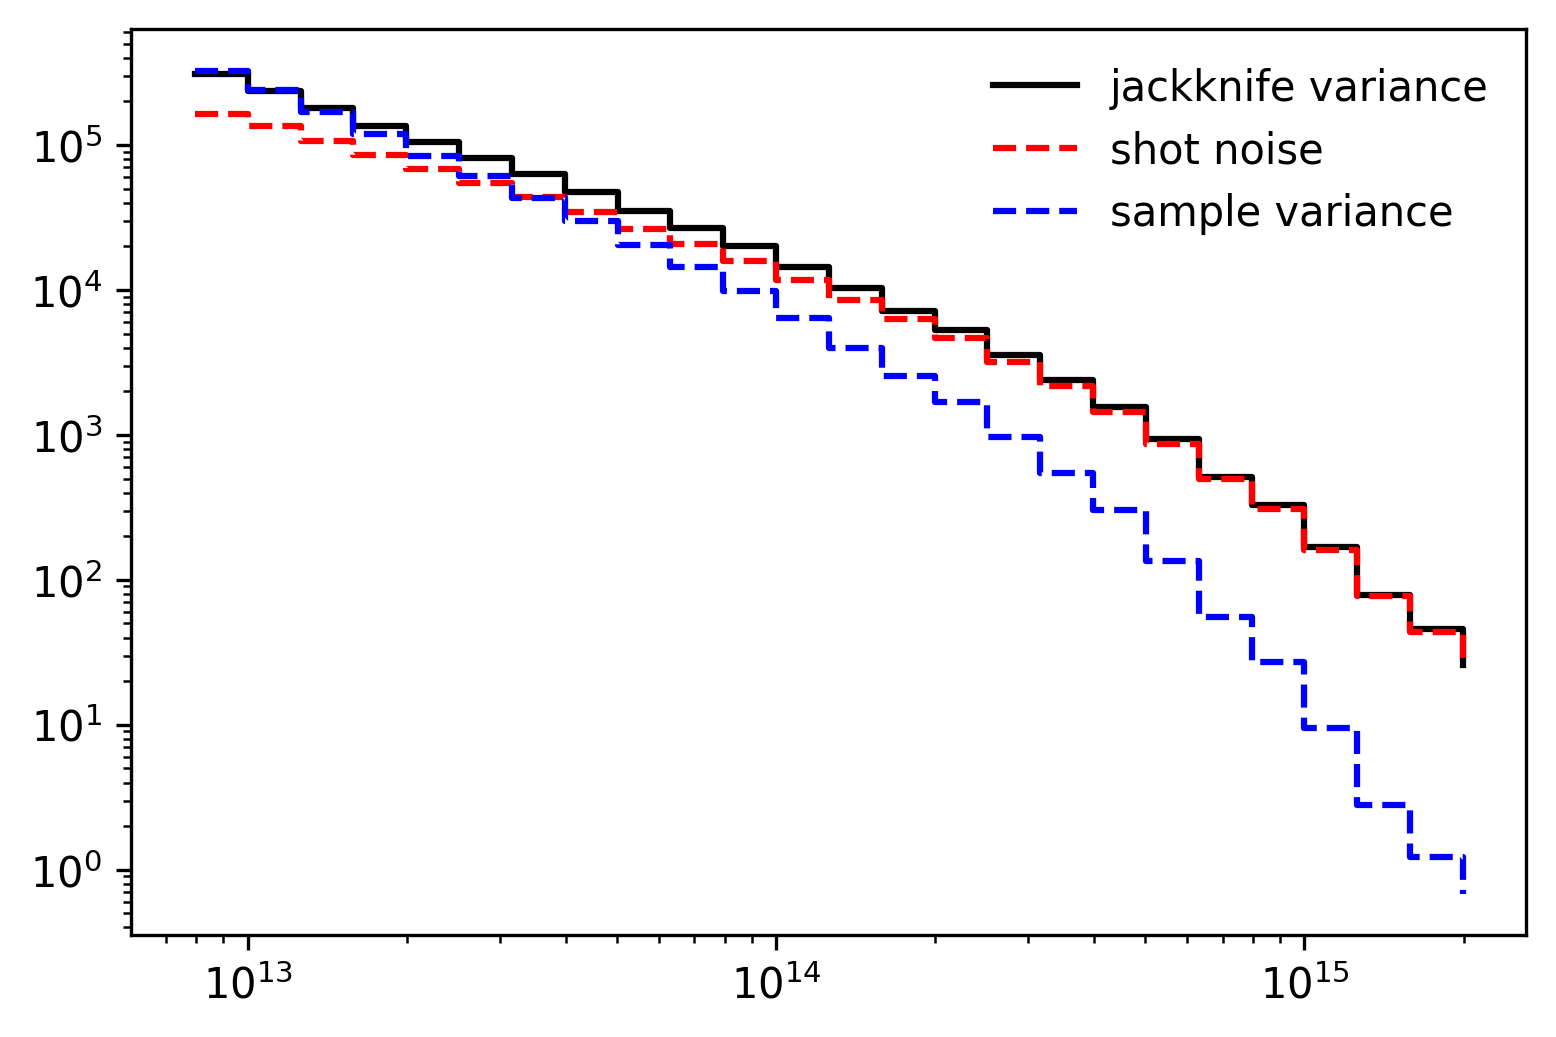

In [84]:
import matplotlib.pyplot as plt
plt.figure(dpi = 300, facecolor = 'w')


plt.step(curr_bin_edges, curr_var,
             where='post', label=r'jackknife variance', c='k', ls='-')

plt.step(curr_bin_edges, curr_N,
             where='post', label=r'shot noise', c='r', ls='--')
plt.step(curr_bin_edges, (sample_variance),
             where='post', label=r'sample variance', c='b', ls='--')
# plt.step(curr_bin_edges, (sample_variance) + curr_N,
#              where='post', label=r'sample variance + shot noise', c='g', ls='-')


plt.legend(frameon = False)
plt.loglog()